In [1]:
import time
from typing import Any, Sequence, Mapping, Optional

In [2]:
# example of fitting a gaussian mixture model with expectation maximization
import numpy as np
from sklearn import mixture
from scipy import stats
from scipy import linalg
from sklearn import model_selection
import pandas as pd
import gymnasium as gym

In [3]:
from rlplg.environments import gridworld, iceworld, redgreen

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

## Tiling

In [5]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count(self):
        return len(self.dictionary)
    
    def fullp(self):
        return len(self.dictionary) >= self.size
    
    def getindex(self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            # TODO: Fail
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles



<Axes: >

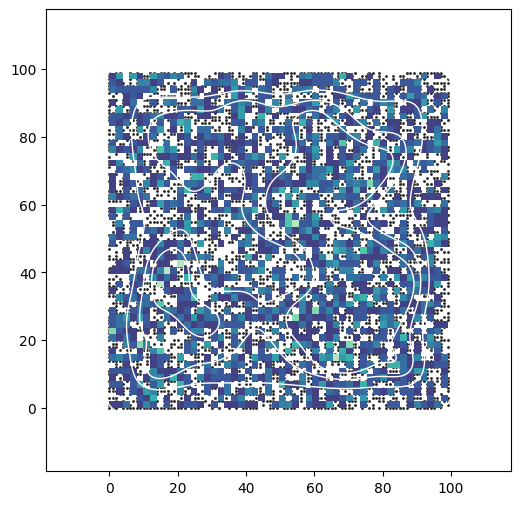

In [6]:
n = 10000
mean = [0, 0]
cov = [(2, .4), (.4, 2)]
# x, y = rng.multivariate_normal(mean, cov, n).T
rng = np.random.default_rng()
# x, y = rng.multivariate_normal(mean, cov, n).T
x = rng.integers(low=0, high=100, size=n)
y = rng.integers(low=0, high=100, size=n)

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

In [7]:
x, y

(array([61, 94, 81, ..., 96, 20, 61]), array([96, 45, 23, ..., 84, 14, 28]))

In [8]:
def pow2geq(lb):
    exp = 1
    while True:
        rs = np.power(2, exp)
        if rs >= lb:
            break
        exp += 1
    return rs

In [9]:
tiling_dim = 10
num_input_dims = 2
numTilings = pow2geq(num_input_dims * 4)
maxSize = tiling_dim * tiling_dim * numTilings
print("numTilings", numTilings)
print("maxsize", maxSize)
iht = IHT(maxSize)
minx, maxx = np.min(x), np.max(x)
miny, maxy = np.min(y), np.max(y)

def mytiles(x, y, numTilings: int):
    # scale values to be between [0, dim]
    return tiles(iht, numTilings, [(x - minx)/(maxx-minx) * tiling_dim,(y-miny)/(maxy-miny) * tiling_dim])

def mywrappedtiles(x, y, numTilings):
    return tileswrap(iht, numTilings, 
                     [(x - minx)/(maxx-minx) * tiling_dim,(y-miny)/(maxy-miny) * tiling_dim],
                     [tiling_dim, tiling_dim]
                    )
    
print("x",  minx, maxx)
print("y",  miny, maxy)
print("mytile", mytiles(1, 50, numTilings=numTilings))
print("mytile", mytiles(10, 24, numTilings=numTilings))
print("mytile", mywrappedtiles(76, 50, numTilings=numTilings))
print("mytile", mywrappedtiles(10, 24, numTilings=numTilings))

maxidx = 0
for i in range(0, 100):
    for j in range(0, 100):
        maxidx = np.max([maxidx] + mywrappedtiles(i, j, numTilings=numTilings))
        
print("maxidx", maxidx)

numTilings 8
maxsize 800
x 0 99
y 0 99
mytile [0, 1, 2, 3, 4, 5, 6, 7]
mytile [8, 9, 10, 11, 12, 13, 14, 15]
mytile [16, 17, 18, 19, 20, 21, 22, 23]
mytile [8, 9, 10, 24, 25, 26, 27, 28]
maxidx 799


In [10]:
def solve_least_squares(
    matrix: np.ndarray, rhs: np.ndarray
) -> np.ndarray:
    try:
        solution, _, _, _ = linalg.lstsq(a=matrix, b=rhs, lapack_driver="gelsy")
        return solution  # type: ignore
    except linalg.LinAlgError as err:
        # the computation failed, likely due to the matix being unsuitable (no solution).
        raise ValueError("Failed to solve linear system") from err

In [11]:
def rmse(v_pred: np.ndarray, v_true: np.ndarray, axis: int):
    if np.shape(v_pred) != np.shape(v_true):
        raise ValueError(
            f"Tensors have different shapes: {np.shape(v_pred)} != {np.shape(v_true)}"
        )
    return np.sqrt(
        np.sum(np.power(v_pred - v_true, 2.0), axis=axis) / np.shape(v_pred)[axis]
    )

## Gym Env

In [12]:
def collection_traj_data(env, steps: int):
    obs, _ = env.reset()
    step = 0
    buffer = []
    while step < steps:
        action = env.action_space.sample()
        next_obs, rew, term, trunc, _,  = env.step(action)
        step += 1
        buffer.append((obs, action, rew))
        obs = next_obs
        if term or trunc:
            obs, _ = env.reset()
    return buffer

In [13]:
def tiling_proj(obs_min, obs_max, tiling_dim: int):
    # obs = np.stack([example[0] for example in buffer])
    assert isinstance(obs_min, np.ndarray)
    assert isinstance(obs_max, np.ndarray)
    wrapwidths = [tiling_dim] * np.size(obs_min)

    # num tilings should a power of 2
    # and at least 4 times greater than
    # the number of dimensions
    num_tilings = pow2geq(np.size(obs_min) * 4)
    max_size = (tiling_dim ** np.size(obs_min)) * num_tilings
    print("Num tilings", num_tilings, "\n", "Flat dim:", max_size)
    iht = IHT(max_size)    
    def mywrappedtiles(obs):
        obs_scaled_01 = (obs - obs_min) / (obs_max - obs_min)
        repr = np.zeros(shape=max_size)
        idx = tileswrap(
            iht, 
            num_tilings, 
            obs_scaled_01 * tiling_dim,
            wrapwidths
        )
        repr[idx] = 1
        return repr
    return mywrappedtiles

In [14]:
env = gym.make("MountainCar-v0")
proj_fn = tiling_proj(
        env.observation_space.low, 
        env.observation_space.high,
        tiling_dim=4
    )
obs, _ = env.reset()
print(obs)
print(proj_fn(obs))

Num tilings 8 
 Flat dim: 128
[-0.56242096  0.        ]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
vars(proj_fn)

{}

In [16]:
class Tiles:
    def __init__(
        self, dims_min: np.ndarray, dims_max: np.ndarray, 
        tiling_dim: int, num_tilings: Optional[int] = None
    ):
        assert isinstance(dims_min, np.ndarray)
        assert isinstance(dims_max, np.ndarray)
        self.dims_max = dims_max
        self.dims_min = dims_min
        self.tiling_dim = tiling_dim
        self.wrapwidths = [tiling_dim] * np.size(dims_min)
    
        # num tilings should a power of 2
        # and at least 4 times greater than
        # the number of dimensions
        self.num_tilings = num_tilings or pow2geq(np.size(dims_min) * 4)
        self.max_size = (tiling_dim ** np.size(dims_min)) * self.num_tilings
        print("Num tilings", self.num_tilings, "\n", "Flat dim:", self.max_size)
        self.iht = IHT(self.max_size)

    def __call__(self, xs):
        xs_scaled_01 = (xs - self.dims_min) / (self.dims_max - self.dims_min)
        repr = np.zeros(shape=self.max_size)
        idx = tileswrap(
            self.iht, 
            self.num_tilings, 
            xs_scaled_01 * self.tiling_dim,
            self.wrapwidths
        )
        repr[idx] = 1
        return repr    

In [17]:
env = gym.make("MountainCar-v0")
tile_fn = Tiles(
        env.observation_space.low,
        env.observation_space.high,
        tiling_dim=4
    )
obs, _ = env.reset()
print(obs)
print(tile_fn(obs))

Num tilings 8 
 Flat dim: 128
[-0.5249507  0.       ]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
vars(tile_fn)

{'dims_max': array([0.6 , 0.07], dtype=float32),
 'dims_min': array([-1.2 , -0.07], dtype=float32),
 'tiling_dim': 4,
 'wrapwidths': [4, 4],
 'num_tilings': 8,
 'max_size': 128,
 'iht': <__main__.IHT at 0x16b5fdc50>}

In [19]:
def delay_reward_data(buffer, delay: int, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])

    # repr: (m1,a1)(m2,a1)..
    mdim = obs.shape[1] * len(np.unique(action))
    num_components = obs.shape[1]

    # build samples
    mask = np.random.choice(len(obs), (sample_size, delay))
    delayed_obs = obs[mask] # batch x delay x dim
    delayed_act = action[mask]
    delayed_rew = np.sum(reward[mask], axis=1) # batch x delay -> batch    
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        for j in range(delay):
            c = num_components*delayed_act[i][j]
            rhat_matrix[i,c:c+num_components] += delayed_obs[i][j]

    return rhat_matrix, delayed_rew

In [20]:
def proj_obs_to_rwest_vec(buffer, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])
    
    # repr: (m1,a1)(m2,a1)..
    mdim = obs.shape[1] * len(np.unique(action))
    num_components = obs.shape[1]

    # build samples
    mask = np.random.choice(len(obs), sample_size)
    delayed_obs = obs[mask] # batch x dim
    delayed_act = action[mask] # batch
    delayed_rew = reward[mask] # batch
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        c = num_components*delayed_act[i]
        rhat_matrix[i,c:c+num_components] += delayed_obs[i]
    return rhat_matrix, delayed_rew

In [21]:
def solve_rwe(env: gym.Env, num_steps: int, sample_size: int, delay: int):
    buffer = collection_traj_data(env, steps=num_steps)
    Xd, yd = delay_reward_data(buffer, delay=delay, sample_size=sample_size)
    return buffer, solve_least_squares(Xd, yd)

In [22]:
def rwe_scatterplot(v_pred, v_true):
    _, ax = plt.subplots(figsize=(6, 6))
    df = pd.DataFrame({
        "x": v_pred,
        "y": v_true,
        "size": np.abs(v_pred - v_true)
    })
    sns.scatterplot(
        df, x="x", y="y", size="size", hue="size", s=5, color=".15"
    )
    # sns.histplot(x=v_pred, y=v_true, bins=50, cmap="mako")
    # sns.kdeplot(x=v_pred, y=v_true, levels=5, color="w")
    ax.set_xlabel("yhat")
    ax.set_ylabel("ytrue")
    ax.set_title("Reward Estimation")

In [23]:
def hashtrick(xs, dim: int):
    ys = np.zeros(dim, dtype=np.int32)
    idx,  = np.where(xs == 1)
    for i in idx:
        ys[i % dim] += 1
    return ys

### Moutain Car

In [24]:
class MCObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, tiling_dim: int, num_tilings: int = None):
        super().__init__(env)
        self.tiles = Tiles(
                env.observation_space.low,
                env.observation_space.high,
                tiling_dim=tiling_dim,
                num_tilings=num_tilings
            )
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.tiles.max_size, dtype=np.int32), 
            high=np.ones(shape=self.tiles.max_size, dtype=np.int32)
        )

    def observation(self, obs):
        return self.tiles(obs)

In [25]:
mc_env = MCObsWrapper(gym.make("MountainCar-v0"), tiling_dim=4)
mc_buffer, mc_sol = solve_rwe(
    mc_env,
    num_steps=150_000, 
    sample_size=50_000,
    delay=2,
)

Num tilings 8 
 Flat dim: 128


In [26]:
len(mc_buffer)

150000

In [27]:
mc_buffer[0][0]

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
mc_env.tiles

In [29]:
mc_sol

array([ 0.0074964 , -0.30378902,  0.57559209, -0.15980693, -0.41782513,
       -0.00952187,  0.05692997, -0.74907552,  0.0074964 , -0.41782513,
       -0.15980693, -0.15980693,  0.05692997, -0.00952187,  0.05692997,
        0.05692997, -0.00952187,  0.57559209, -0.00952187, -0.74907552,
        0.57559209, -0.30378902,  0.57559209, -0.15980693, -0.30378902,
       -0.74907552, -0.41782513,  0.0074964 ,  0.0074964 , -0.74907552,
       -0.41782513, -0.41782513, -0.30378902,  0.0074964 ,  0.0074964 ,
       -0.30378902, -0.41782513, -0.74907552, -0.74907552, -0.30378902,
        0.57559209, -0.30378902,  0.57559209,  0.        ,  0.        ,
       -0.15980693,  0.05692997,  0.        , -0.30378902, -0.74907552,
        0.05692997, -0.74907552, -0.00952187,  0.        ,  0.05692997,
        0.57559209,  0.        , -0.15980693,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [30]:
mc_eval_X, mc_eval_y = proj_obs_to_rwest_vec(mc_buffer, sample_size=10_000)

In [31]:
np.matmul(mc_eval_X, mc_sol)

array([-1., -1., -1., ..., -1., -1., -1.])

In [32]:
rmse(
    v_pred=np.matmul(mc_eval_X, mc_sol), 
    v_true=mc_eval_y,
    axis=0
)

0.021855603946063208

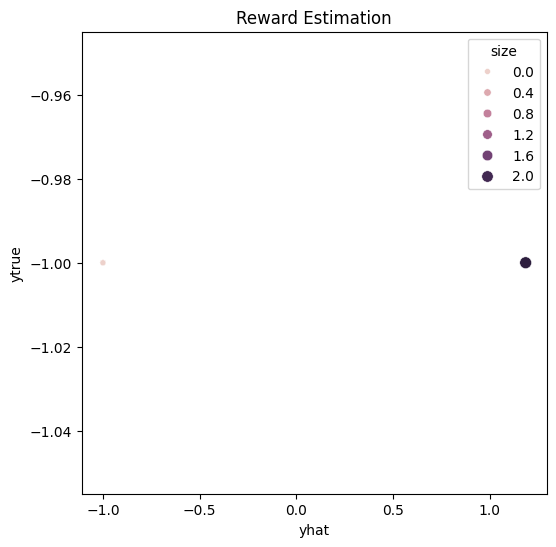

In [33]:
rwe_scatterplot(
    v_pred=np.matmul(mc_eval_X, mc_sol), 
    v_true=mc_eval_y
)

### Grid World (Different Rewards)

In [34]:
class GWObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, tiling_dim: int, num_tilings: int = None):
        super().__init__(env)
        self.tiles = Tiles(
                np.array([0, 0], np.int32),
                np.array(
                    [env.observation_space["agent"][0].n, env.observation_space["agent"][1].n]
                ),
                tiling_dim=tiling_dim,
                num_tilings=num_tilings
            )
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.tiles.max_size, dtype=np.int32), 
            high=np.ones(shape=self.tiles.max_size, dtype=np.int32)
        )

    def observation(self, obs):
        return self.tiles(obs["agent"])

In [35]:
size, cliffs, exits, start = gridworld.parse_grid_from_text(
    ["oooooooooooo", "oooooooooooo", "oooooooooooo", "sxxxxxxxxxxg"]
)
print(size, cliffs, exits, start)
gw_env = GWObsWrapper(
    gridworld.GridWorld(size, cliffs, exits, start),
    tiling_dim=5
)
gw_buffer, gw_sol = solve_rwe(
    gw_env,
    num_steps=150_000, 
    sample_size=50_000,
    delay=2,
)

(4, 12) [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)] [(3, 11)] (3, 0)
Num tilings 8 
 Flat dim: 200


In [36]:
np.unique([ex[2] for ex in gw_buffer])

array([-100.,   -1.])

In [37]:
gw_sol

array([ 2.62311014e+01, -3.89015734e+00, -3.89015734e+00, -3.89015734e+00,
       -3.89015734e+00, -3.89015734e+00, -3.89015734e+00, -3.89015734e+00,
        2.73072573e-01, -1.14145446e+00, -4.96486371e-01,  9.47246342e-01,
        1.63420632e-01,  4.66686881e-01, -8.14849887e-01, -3.97635708e-01,
        1.53799496e-01,  1.09504994e-01, -6.90739688e-01, -5.17754800e-01,
        5.69961829e-01, -1.84509075e+00, -2.47041742e-01,  1.16954838e+00,
       -3.12381257e-01,  8.73498027e-01,  8.17436566e-01, -1.47718949e-01,
       -4.89677462e-01, -3.53228719e-01,  8.26034288e-02, -5.48831303e-01,
       -5.25923275e-01,  1.65339713e-01, -2.98834409e-01, -1.41024407e-01,
       -4.33310235e-01, -8.44986381e-01,  4.84119724e-01,  7.96834464e-01,
       -1.97454453e-01, -1.10148383e+00, -1.42957541e+00,  4.89636205e-01,
        8.02909679e-01,  4.43564577e-01,  5.02555853e-01, -7.75951698e-01,
        6.12429319e-01,  6.03404008e-01, -1.34356123e+00, -7.92506820e-01,
        2.24524552e-01, -

In [38]:
gw_env.tiles

In [39]:
gw_eval_X, gw_eval_y = proj_obs_to_rwest_vec(gw_buffer, sample_size=1_000_000)

In [40]:
np.unique(gw_eval_y)

array([-100.,   -1.])

In [41]:
gw_eval_X.shape, gw_eval_y.shape

((1000000, 800), (1000000,))

In [42]:
np.unique(np.around(np.matmul(gw_eval_X, gw_sol), 2))

array([-100.,   -1.])

In [43]:
rmse(
    v_pred=np.matmul(gw_eval_X, gw_sol), 
    v_true=gw_eval_y,
    axis=0
)

3.425247354856174e-14

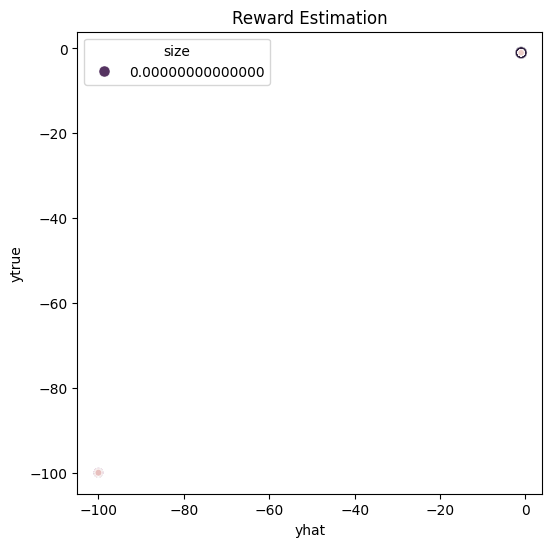

In [44]:
rwe_scatterplot(
    v_pred=np.matmul(gw_eval_X, gw_sol), 
    v_true=gw_eval_y
)

### RedGreen

In [45]:
class RGObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, tiling_dim: int, num_tilings: int = None):
        super().__init__(env)
        self.tiles = Tiles(
                np.array([0], np.int32),
                np.array(
                    [env.observation_space["pos"].n]
                ),
                tiling_dim=tiling_dim,
                num_tilings=num_tilings
            )
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.tiles.max_size, dtype=np.int32), 
            high=np.ones(shape=self.tiles.max_size, dtype=np.int32)
        )

    def observation(self, obs):
        return self.tiles(obs["pos"])

In [46]:
rg_env = RGObsWrapper(
    redgreen.RedGreenSeq(["red", "green", "red", "green", "wait", "green"]),
    tiling_dim=2
)
rg_buffer, rg_sol = solve_rwe(
    rg_env,
    num_steps=150_000, 
    sample_size=50_000,
    delay=2,
)

Num tilings 4 
 Flat dim: 8


In [47]:
rg_buffer[0][0]

array([1., 1., 1., 1., 0., 0., 0., 0.])

In [48]:
np.unique([np.around(ex[2], 2) for ex in rg_buffer])

array([-1.])

In [49]:
rg_env.tiles

In [50]:
rg_sol

array([-1.06149118, -0.00252137,  0.07431152, -0.01029897, -0.01029897,
        0.07431152, -0.00252137, -1.06149118, -0.02260694, -0.85379197,
       -0.09882584, -0.02477524, -0.02477524, -0.09882584, -0.85379197,
       -0.02260694, -0.10419372, -0.59690739, -0.0199136 , -0.27898528,
       -0.27898528, -0.0199136 , -0.59690739, -0.10419372])

In [51]:
rg_eval_X, rg_eval_y = proj_obs_to_rwest_vec(rg_buffer, sample_size=10_000)

In [52]:
rg_eval_X.shape, rg_eval_y.shape

((10000, 24), (10000,))

In [53]:
np.matmul(rg_eval_X, rg_sol)

array([-1., -1., -1., ..., -1., -1., -1.])

In [54]:
rmse(
    v_pred=np.matmul(rg_eval_X, rg_sol), 
    v_true=rg_eval_y,
    axis=0
)

3.1740200593764313e-15

### Lunda Lander

In [55]:
class LunarLinearReward(gym.Wrapper):
    """
    Lunar Lander with linear rewards
    """
    def __init__(self, env):
        super().__init__(env)
        self.prev_shaping = None

    def step(self, action):
        next_obs, reward, term, trunc, info = self.env.step(action)
        shaping = (
            -100 * next_obs[0] 
            -100 * next_obs[1]
            # -100 * next_obs[2]
            # -100 * next_obs[3]
            # -100 * next_obs[4]
             + 10 * next_obs[6]
             + 10 * next_obs[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        linear_reward = shaping
        return np.array(next_obs, dtype=np.float32), linear_reward, term, trunc, info
    

In [56]:
class LLObsWrapper(gym.ObservationWrapper):
    def __init__(
        self, env, tiling_dim: int, num_tilings: int = None, hash_dim: Optional[int] = None
    ):
        super().__init__(env)
        self.hash_dim = hash_dim
        self.tiles = Tiles(
            dims_min=env.observation_space.low[:6],
            dims_max=env.observation_space.high[:6],
            tiling_dim=tiling_dim,
            num_tilings=num_tilings
        )
        # TODO: hash dim
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.tiles.max_size, dtype=np.int32), 
            high=np.ones(shape=self.tiles.max_size, dtype=np.int32)
        )
        self.prev_obs = None

    def observation(self, obs):
        xs = self.tiles(obs[:6])
        if self.hash_dim:
            xs = hashtrick(xs, dim=self.hash_dim)
        # return np.concatenate([obs, np.array([1])]) 
        return np.concatenate([obs[:6], obs[6:]])

In [57]:
# another way to encode this; skip last two binary dimensions, concat them
lunar_env = LLObsWrapper(
    LunarLinearReward(gym.make("LunarLander-v3")), tiling_dim=4, hash_dim=128
)
lunar_buffer, lunar_sol = solve_rwe(
    lunar_env,
    num_steps=150_000, 
    sample_size=50_000,
    delay=2,
)

Num tilings 32 
 Flat dim: 131072


In [58]:
lunar_buffer[0][0], lunar_buffer[1][0]

(array([-0.00579834,  1.4015113 , -0.587318  , -0.41817805,  0.00672553,
         0.1330362 ,  0.        ,  0.        ], dtype=float32),
 array([-0.0116828 ,  1.3915334 , -0.5972632 , -0.44352922,  0.0154522 ,
         0.17455044,  0.        ,  0.        ], dtype=float32))

In [59]:
np.unique([np.around(ex[2], 2) for ex in lunar_buffer])

array([-247.52, -247.27, -246.98, ...,  139.97,  140.26,  142.61])

<Axes: ylabel='Count'>

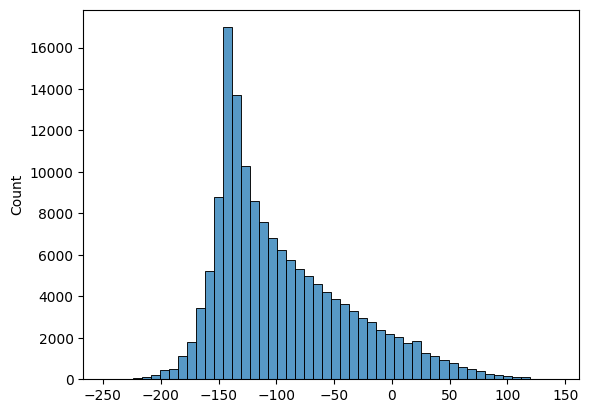

In [60]:
sns.histplot([np.around(ex[2], 2) for ex in lunar_buffer], bins=50)

In [61]:
lunar_env.tiles

In [62]:
lunar_eval_X, lunar_eval_y = proj_obs_to_rwest_vec(lunar_buffer, sample_size=50_000)

In [63]:
lunar_eval_X.shape, lunar_eval_y.shape

((50000, 32), (50000,))

In [64]:
lunar_eval_y

array([-156.42587431, -140.36464989, -136.76070198, ...,  -65.64371362,
       -132.30070584, -145.92232946])

In [65]:
np.matmul(lunar_eval_X, lunar_sol)

array([-156.70949654, -140.22628044, -136.70820165, ...,  -65.24002465,
       -132.24036807, -146.3324355 ])

In [66]:
rmse(
    v_pred=np.matmul(lunar_eval_X, lunar_sol), 
    v_true=lunar_eval_y,
    axis=0
)

1.3194218176400063

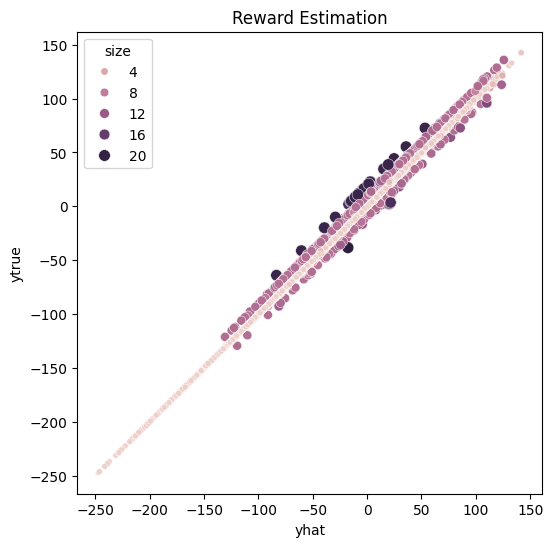

In [67]:
rwe_scatterplot(
    v_pred=np.matmul(lunar_eval_X, lunar_sol), 
    v_true=lunar_eval_y
)